# DEEP REINFORCEMENT LEARNING MARIO

In [125]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# IMPORT THE LIBRARIES GLOBALLY

In [126]:
import io
import os 
import gym
import base64
from gym import wrappers
from IPython.display import HTML
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import gym_super_mario_bros
from google.colab import drive
from nes_py.wrappers import JoypadSpace
from IPython import display as ipythondisplay
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [128]:
COMPLEX_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left'],
 ['left', 'A'],
 ['left', 'B'],
 ['left', 'A', 'B'],
 ['down'],
 ['up']]

### MOUNT THE GDRIVE AND CHANGE DIRECTORY

In [129]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Finals/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
#Game setup
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [131]:
env.action_space

Discrete(12)

In [132]:
#Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

Exception ignored in: <function Monitor.__del__ at 0x7fa39d77d320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 289, in __del__
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 178, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/nes_py/nes_env.py", line 346, in close
ValueError: env has already been closed.


In [133]:
state = env.reset()

In [134]:
state, reward, done, info = env.step([5])

### VISUALIZE THE ENVIRONMENT

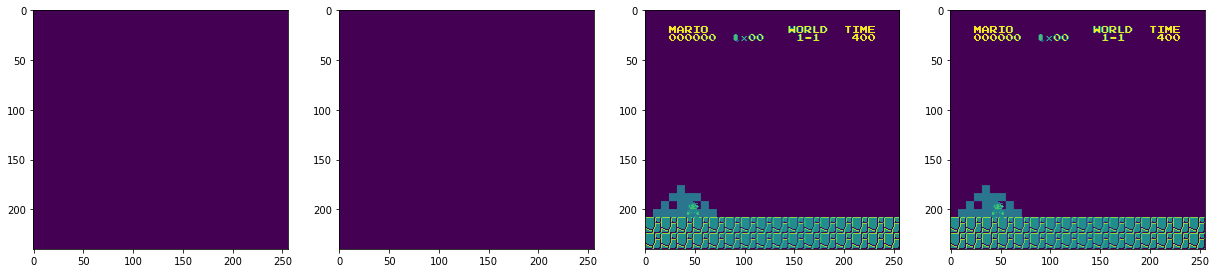

In [135]:
plt.figure(figsize=(21,17))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [136]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'besto_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [137]:
CHECKPOINT_DIR = 'train'
LOG_DIR = 'logs'

In [138]:
#Model saving every 50000 timesteps
callback = TrainAndLoggingCallback(check_freq=50000, save_path=CHECKPOINT_DIR)

In [139]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


# TRAIN THE MODEL

In [140]:
#Train the model
model.learn(total_timesteps=500000, callback=callback)

Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 5181       |
|    total_timesteps      | 358400     |
| train/                  |            |
|    approx_kl            | 0.00959196 |
|    clip_fraction        | 0.104      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.613     |
|    explained_variance   | 0.228      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00741    |
|    n_updates            | 6990       |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 0.0642     |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 69          |
|    iterations           | 701         |
|    time_elapsed         | 5188        |
|    total_timesteps      | 358912      |
| train/                  |             |
|    approx_kl            | 0.013901908 |
|    clip_fraction        | 0.161      

### SAVE THE MODEL

In [141]:
model.save('testmodel')

In [142]:
#Load model
model = PPO.load('train/besto_model_500000')

### VIRTUAL ENVIRONMENT SETUP

In [143]:
#Game setup
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = wrappers.Monitor(env, "./videos", force=True)
env.reset()
for _ in range(5000):
  state, reward, done, info = env.step(env.action_space.sample())
  if done: break
env.close()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


### VIDEO PLAYBACK

In [144]:
video = io.open('./videos/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="480" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))